In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping
from keras.preprocessing import image

from sklearn.metrics import confusion_matrix, classification_report

# Data loading

In [2]:
batch_size = 32
im_size = (224,224)

In [28]:
train_ds = keras.preprocessing.image_dataset_from_directory(
  './sampled_classes/train/', 
  labels='inferred',
  label_mode='categorical', 
  seed=123, 
  batch_size=batch_size, 
  image_size=im_size
)

val_ds = keras.preprocessing.image_dataset_from_directory(
  './sampled_classes/validation/', 
  labels='inferred',
  label_mode='categorical', 
  seed=123, 
  batch_size=batch_size, 
  image_size=im_size
)

Found 37548 files belonging to 7 classes.
Found 4690 files belonging to 7 classes.


In [29]:
cls = train_ds.class_names
cls

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Model

In [85]:

model = Sequential([
    layers.RandomRotation(factor=1.0, input_shape=(im_size[0], im_size[1], 3)),
    layers.RandomFlip(mode='horizontal'),
    layers.Rescaling(1./255),

    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),

    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),

    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(7, activation='softmax'),
])

In [87]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
earlystopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 32,
    restore_best_weights = True,
    verbose=2
)

In [86]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_11 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_flip_7 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 112, 112, 16)    

# Model Training

In [89]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=256,
    callbacks=earlystopping
)

Epoch 1/256
219/219 [==============================] - 30s 129ms/step - loss: 1.8502 - accuracy: 0.2173 - val_loss: 1.5809 - val_accuracy: 0.3794
Epoch 2/256
219/219 [==============================] - 27s 123ms/step - loss: 1.4583 - accuracy: 0.4053 - val_loss: 1.4672 - val_accuracy: 0.3874
Epoch 3/256
219/219 [==============================] - 28s 126ms/step - loss: 1.3116 - accuracy: 0.4800 - val_loss: 1.2850 - val_accuracy: 0.4926
Epoch 4/256
219/219 [==============================] - 28s 128ms/step - loss: 1.2576 - accuracy: 0.5120 - val_loss: 1.2925 - val_accuracy: 0.4651
Epoch 5/256
219/219 [==============================] - 30s 136ms/step - loss: 1.1767 - accuracy: 0.5439 - val_loss: 1.2255 - val_accuracy: 0.4983
Epoch 6/256
219/219 [==============================] - 28s 127ms/step - loss: 1.1336 - accuracy: 0.5690 - val_loss: 1.2240 - val_accuracy: 0.4920
Epoch 7/256
219/219 [==============================] - 28s 127ms/step - loss: 1.0968 - accuracy: 0.5763 - val_loss: 1.1884 -

## Evaluation

In [90]:
model.evaluate(val_ds)

55/55 [==============================] - 3s 52ms/step - loss: 1.1596 - accuracy: 0.5743


[1.1596392393112183, 0.5742856860160828]

In [15]:
def history_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(history.epoch[-1]+1)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()



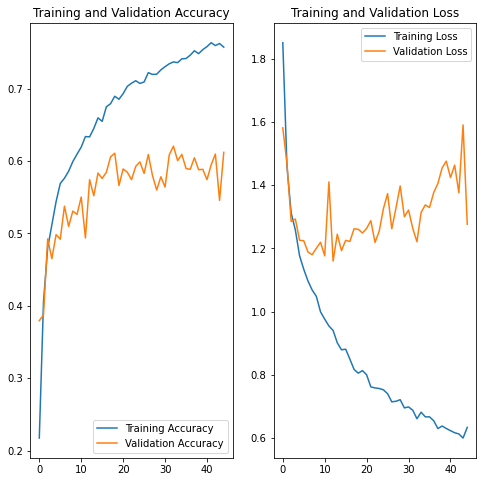

In [91]:
history_plot(history)

In [92]:
y_true = []
y_pred = []
for images, labels in val_ds:
    y_true.append(np.argmax(labels, axis=1)) 
    y_pred.append(np.argmax(model.predict(images), axis=1))
y_true = np.hstack(y_true) 
y_pred = np.hstack(y_pred) 

1/1 [==============================] - 0s 82ms/step


In [93]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.56      0.54       250
           1       0.45      0.38      0.41       250
           2       0.41      0.42      0.42       250
           3       0.60      0.46      0.52       250
           4       0.51      0.64      0.57       250
           5       0.66      0.60      0.63       250
           6       0.86      0.96      0.91       250

    accuracy                           0.57      1750
   macro avg       0.57      0.57      0.57      1750
weighted avg       0.57      0.57      0.57      1750



In [94]:
conf = confusion_matrix(y_true, y_pred)
conf

array([[139,  23,  20,  25,  35,   8,   0],
       [ 61,  96,  31,  26,  10,   2,  24],
       [ 22,  16, 106,  19,  53,  30,   4],
       [ 25,  61,  24, 114,   0,  26,   0],
       [ 21,   8,  43,   1, 161,  11,   5],
       [  0,   9,  23,   4,  59, 149,   6],
       [  0,   0,  10,   0,   0,   0, 240]], dtype=int64)

In [71]:
model.save('./models/model')

INFO:tensorflow:Assets written to: ./models/model\assets


INFO:tensorflow:Assets written to: ./models/model\assets


In [95]:
test_ds = keras.preprocessing.image_dataset_from_directory(
  './sampled_classes/test/', 
  labels='inferred',
  label_mode='categorical', 
  seed=123, 
  batch_size=batch_size, 
  image_size=im_size
)

Found 1002 files belonging to 7 classes.


In [96]:
model.evaluate(test_ds)

32/32 [==============================] - 3s 77ms/step - loss: 0.9374 - accuracy: 0.5828


[0.9374444484710693, 0.5828343033790588]

# Transfer learning

In [22]:
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions

In [67]:
model_t = ResNet50(
    include_top=True,
    weights = 'imagenet'
)

574710816/574710816 [==============================] - 321s 1us/step


In [91]:
def get_labels(path):
    original_im = keras.preprocessing.image.load_img(path, target_size = im_size)
    image_array = keras.preprocessing.image.img_to_array(original_im)
    image_array = image_array.reshape((1, image_array.shape[0], image_array.shape[1], image_array.shape[2]))
    prepared_im = preprocess_input(image_array)
    pred = model_t.predict(prepared_im)
    labels = decode_predictions(pred)
    return labels

In [94]:
for path in os.listdir('./sampled_classes/test/akiec')[:10]:
    print(get_labels(f'./sampled_classes/test/akiec/{path}'))

1/1 [==============================] - 0s 18ms/step
[[('n01776313', 'tick', 0.36347976), ('n01774384', 'black_widow', 0.16375616), ('n02219486', 'ant', 0.14996946), ('n01775062', 'wolf_spider', 0.01841793), ('n01770081', 'harvestman', 0.017559603)]]
1/1 [==============================] - 0s 18ms/step
[[('n01776313', 'tick', 0.2178584), ('n04525038', 'velvet', 0.08081351), ('n01770393', 'scorpion', 0.025895908), ('n03532672', 'hook', 0.016255876), ('n03804744', 'nail', 0.016241591)]]
1/1 [==============================] - 0s 19ms/step
[[('n01774384', 'black_widow', 0.1139153), ('n01775062', 'wolf_spider', 0.111394845), ('n01776313', 'tick', 0.08307785), ('n02219486', 'ant', 0.056354478), ('n02231487', 'walking_stick', 0.05534977)]]
1/1 [==============================] - 0s 17ms/step
[[('n01770081', 'harvestman', 0.9283527), ('n01776313', 'tick', 0.025633568), ('n02233338', 'cockroach', 0.011861203), ('n02168699', 'long-horned_beetle', 0.0099882865), ('n02231487', 'walking_stick', 0.0076

# New Model

In [23]:
model_n = ResNet50(
    include_top=False,
    weights = 'imagenet'
)

In [24]:
for l in model_n.layers:
    l.trainable=False

In [25]:
model_n.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [30]:
new_model = Sequential([
    layers.RandomRotation(factor=1, input_shape=(im_size[0], im_size[1], 3)),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    model_n,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(7, activation='softmax'),
])

In [41]:
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_6 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_flip_6 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_translation_3 (Rando  (None, 224, 224, 3)      0         
 mTranslation)                                                   
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten_5 (Flatten)         (None, 100352)           

In [31]:
new_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## preprocessing data

In [32]:
train_ds_p = train_ds.map(lambda x,y : (preprocess_input(x), y))
val_ds_p = val_ds.map(lambda x,y : (preprocess_input(x), y))

## training

In [36]:
earlystopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 32,
    restore_best_weights = True,
    verbose=2
)

In [38]:
history = new_model.fit(
    train_ds_p,
    validation_data=val_ds_p,
    epochs=30,
    callbacks=earlystopping
)

Epoch 1/30
219/219 [==============================] - 108s 491ms/step - loss: 1.3155 - accuracy: 0.4553 - val_loss: 1.5054 - val_accuracy: 0.4874
Epoch 2/30
219/219 [==============================] - 108s 489ms/step - loss: 1.2774 - accuracy: 0.4719 - val_loss: 1.6779 - val_accuracy: 0.4731
Epoch 3/30
219/219 [==============================] - 108s 490ms/step - loss: 1.2606 - accuracy: 0.4844 - val_loss: 1.5550 - val_accuracy: 0.5280
Epoch 4/30
219/219 [==============================] - 108s 491ms/step - loss: 1.2426 - accuracy: 0.4983 - val_loss: 1.4591 - val_accuracy: 0.4817
Epoch 5/30
219/219 [==============================] - 108s 492ms/step - loss: 1.2197 - accuracy: 0.5093 - val_loss: 1.4670 - val_accuracy: 0.5629
Epoch 6/30
219/219 [==============================] - 108s 490ms/step - loss: 1.2009 - accuracy: 0.5111 - val_loss: 1.7255 - val_accuracy: 0.4857
Epoch 7/30
219/219 [==============================] - 108s 491ms/step - loss: 1.2158 - accuracy: 0.5090 - val_loss: 1.2738 -

## evaluation

In [39]:
new_model.evaluate(val_ds_p)

55/55 [==============================] - 6s 100ms/step - loss: 1.9544 - accuracy: 0.5531


[1.9543960094451904, 0.5531428456306458]

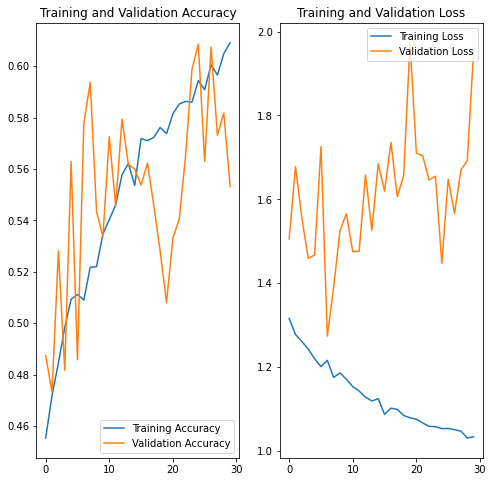

In [40]:
history_plot(history)

In [42]:
y_true = []
y_pred = []
for images, labels in val_ds_p:
    y_true.append(np.argmax(labels, axis=1)) 
    y_pred.append(np.argmax(new_model.predict(images), axis=1))
y_true = np.hstack(y_true) 
y_pred = np.hstack(y_pred) 

1/1 [==============================] - 1s 774ms/step


In [44]:
print(classification_report(y_true, y_pred))
conf = confusion_matrix(y_true, y_pred)
conf

              precision    recall  f1-score   support

           0       0.53      0.48      0.50       250
           1       0.77      0.47      0.59       250
           2       0.38      0.72      0.50       250
           3       0.86      0.56      0.67       250
           4       0.40      0.52      0.45       250
           5       0.54      0.59      0.56       250
           6       0.99      0.54      0.70       250

    accuracy                           0.55      1750
   macro avg       0.64      0.55      0.57      1750
weighted avg       0.64      0.55      0.57      1750



array([[119,   0,  98,   9,  12,  12,   0],
       [ 62, 118,  43,   5,  20,   2,   0],
       [ 13,   1, 179,   0,  48,   9,   0],
       [ 24,  13,  24, 139,  37,  13,   0],
       [  6,   6,  96,   6, 131,   5,   0],
       [  0,   5,  23,   3,  71, 147,   1],
       [  0,  10,  10,   0,  10,  85, 135]], dtype=int64)

In [114]:
for l in new_model.layers[1].layers:
    l.trainable=True

In [115]:
new_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_12 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten_12 (Flatten)        (None, 100352)            0         
                                                                 
 dense_24 (Dense)            (None, 128)               12845184  
                                                                 
 dropout_47 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 7)                 903       
                                                     

In [116]:
history = new_model.fit(
    train_ds_p,
    validation_data=val_ds_p,
    epochs=50,
    callbacks=earlystopping
)

Epoch 1/50
219/219 [==============================] - 36s 163ms/step - loss: 0.9765 - accuracy: 0.6341 - val_loss: 1.3170 - val_accuracy: 0.5680
Epoch 2/50
219/219 [==============================] - 39s 175ms/step - loss: 0.9233 - accuracy: 0.6427 - val_loss: 1.1933 - val_accuracy: 0.5880
Epoch 3/50
219/219 [==============================] - 38s 169ms/step - loss: 0.8394 - accuracy: 0.6726 - val_loss: 1.1229 - val_accuracy: 0.6491
Epoch 4/50
219/219 [==============================] - 37s 167ms/step - loss: 0.7999 - accuracy: 0.6917 - val_loss: 1.3438 - val_accuracy: 0.6194
Epoch 5/50
219/219 [==============================] - 37s 168ms/step - loss: 0.7731 - accuracy: 0.6929 - val_loss: 1.5319 - val_accuracy: 0.6040
Epoch 6/50
219/219 [==============================] - 37s 167ms/step - loss: 0.7747 - accuracy: 0.6950 - val_loss: 1.2980 - val_accuracy: 0.5966
Epoch 7/50
219/219 [==============================] - 37s 166ms/step - loss: 0.7407 - accuracy: 0.7023 - val_loss: 1.3382 - val_ac

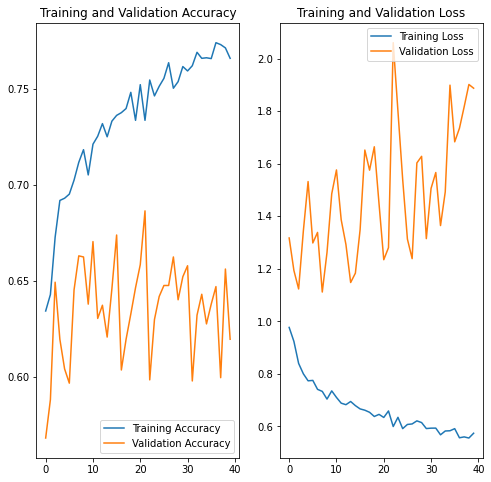

In [117]:
history_plot(history)

In [119]:
y_true = []
y_pred = []
for images, labels in val_ds_p:
    y_true.append(np.argmax(labels, axis=1)) 
    y_pred.append(np.argmax(new_model.predict(images), axis=1))
y_true = np.hstack(y_true) 
y_pred = np.hstack(y_pred) 

1/1 [==============================] - 0s 28ms/step


In [120]:
print(classification_report(y_true, y_pred))
conf = confusion_matrix(y_true, y_pred)
conf

              precision    recall  f1-score   support

           0       0.69      0.51      0.59       250
           1       0.56      0.76      0.65       250
           2       0.72      0.52      0.61       250
           3       0.94      0.80      0.87       250
           4       0.43      0.72      0.54       250
           5       0.70      0.68      0.69       250
           6       0.95      0.65      0.77       250

    accuracy                           0.66      1750
   macro avg       0.71      0.66      0.67      1750
weighted avg       0.71      0.66      0.67      1750



array([[127,  41,  23,   0,  55,   4,   0],
       [ 24, 190,   6,   6,  21,   0,   3],
       [ 17,  20, 131,   3,  68,   9,   2],
       [  0,  24,   0, 201,  25,   0,   0],
       [  5,  24,  17,   3, 179,  20,   2],
       [  0,  11,   6,   1,  61, 170,   1],
       [ 10,  29,   0,   0,  10,  39, 162]], dtype=int64)

In [45]:
new_model.save('./models/transfer_model')

INFO:tensorflow:Assets written to: ./models/transfer_model\assets


INFO:tensorflow:Assets written to: ./models/transfer_model\assets


In [124]:
test_ds_p = test_ds.map(lambda x,y : (preprocess_input(x), y))

In [126]:
new_model.evaluate(val_ds_p)

55/55 [==============================] - 8s 129ms/step - loss: 1.1112 - accuracy: 0.6629


[1.1111738681793213, 0.6628571152687073]

In [127]:
new_model.evaluate(test_ds_p)

32/32 [==============================] - 5s 123ms/step - loss: 0.9444 - accuracy: 0.6038


[0.9443709850311279, 0.6037924289703369]

# AlexNet

In [30]:
alexnet = Sequential([
    layers.RandomRotation(factor=1, input_shape=(im_size[0], im_size[1], 3)),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.Conv2D(96, kernel_size=(11, 11), strides=(4,4)),
    layers.BatchNormalization(),
    layers.MaxPool2D((3,3), strides=2),
    layers.Conv2D(128, kernel_size=(5, 5), padding = 'same'),
    layers.BatchNormalization(),
    layers.MaxPool2D((3,3), strides=2),
    layers.Conv2D(384, kernel_size=(3, 3), padding = 'same', activation='relu'),
    layers.Conv2D(384, kernel_size=(3, 3), padding = 'same', activation='relu'),
    layers.Conv2D(128, kernel_size=(3, 3), padding = 'same'),
    layers.BatchNormalization(),
    layers.MaxPool2D((3,3), strides=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

In [31]:
alexnet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_3 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_flip_3 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_translation_2 (Rando  (None, 224, 224, 3)      0         
 mTranslation)                                                   
                                                                 
 conv2d_15 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization_9 (Batc  (None, 54, 54, 96)      

In [32]:
alexnet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
early = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=8,
    verbose=2,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)


In [39]:
history = alexnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=early
)

Epoch 1/15
1174/1174 [==============================] - 473s 402ms/step - loss: 1.2422 - accuracy: 0.5011 - val_loss: 1.2015 - val_accuracy: 0.5358
Epoch 2/15
1174/1174 [==============================] - 467s 398ms/step - loss: 1.1382 - accuracy: 0.5583 - val_loss: 1.5335 - val_accuracy: 0.4544
Epoch 3/15
1174/1174 [==============================] - 474s 403ms/step - loss: 1.0348 - accuracy: 0.6038 - val_loss: 1.4491 - val_accuracy: 0.5299
Epoch 4/15
1174/1174 [==============================] - 474s 403ms/step - loss: 0.9591 - accuracy: 0.6414 - val_loss: 1.4868 - val_accuracy: 0.5593
Epoch 5/15
1174/1174 [==============================] - 474s 403ms/step - loss: 0.8666 - accuracy: 0.6805 - val_loss: 2.3472 - val_accuracy: 0.5704
Epoch 6/15
1174/1174 [==============================] - 476s 405ms/step - loss: 0.8004 - accuracy: 0.7043 - val_loss: 1.0794 - val_accuracy: 0.6665
Epoch 7/15
1174/1174 [==============================] - 474s 403ms/step - loss: 0.7499 - accuracy: 0.7296 - val_

In [40]:
alexnet.save('./models/alexnet')

INFO:tensorflow:Assets written to: ./models/alexnet\assets


INFO:tensorflow:Assets written to: ./models/alexnet\assets


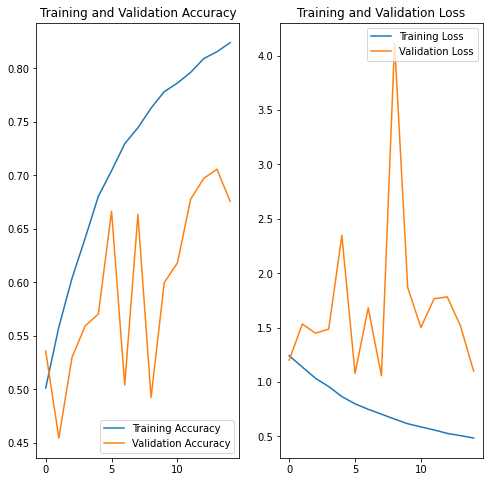

In [41]:

history_plot(history)

In [42]:
y_true = []
y_pred = []
for images, labels in val_ds:
    y_true.append(np.argmax(labels, axis=1)) 
    y_pred.append(np.argmax(alexnet.predict(images), axis=1))
y_true = np.hstack(y_true) 
y_pred = np.hstack(y_pred) 

1/1 [==============================] - 0s 28ms/step


In [43]:
print(classification_report(y_true, y_pred))
conf = confusion_matrix(y_true, y_pred)
conf

              precision    recall  f1-score   support

           0       0.65      0.39      0.49       670
           1       0.66      0.75      0.70       670
           2       0.45      0.62      0.52       670
           3       0.98      0.58      0.73       670
           4       0.50      0.75      0.60       670
           5       0.88      0.64      0.74       670
           6       0.94      1.00      0.97       670

    accuracy                           0.68      4690
   macro avg       0.72      0.68      0.68      4690
weighted avg       0.72      0.68      0.68      4690



array([[261, 101, 247,   0,  61,   0,   0],
       [ 13, 500,  53,   0,  65,  26,  13],
       [ 36,  36, 414,   0, 159,  19,   6],
       [ 55, 112,  56, 391,  56,   0,   0],
       [ 30,   6, 102,   6, 502,  12,  12],
       [  6,   6,  51,   1, 165, 431,  10],
       [  0,   0,   0,   0,   0,   0, 670]], dtype=int64)

In [44]:
test_ds = keras.preprocessing.image_dataset_from_directory(
  './sampled_classes/test/', 
  labels='inferred',
  label_mode='categorical', 
  seed=123, 
  batch_size=batch_size, 
  image_size=im_size
)

Found 1002 files belonging to 7 classes.


In [45]:
alexnet.evaluate(test_ds)

32/32 [==============================] - 4s 103ms/step - loss: 0.9056 - accuracy: 0.6427


[0.9056447148323059, 0.6427145600318909]

In [46]:
alexnet.save('./models/alexnet_small.h5' )